In [2]:
using DifferentialEquations
using PyCall
import Random
# using PyPlot
using Statistics
using BenchmarkTools
using Base.Threads
using Plots
import PyPlot
pl = PyPlot;

In [3]:
function KM_model(du, u, p, t)
    
    omega = p[3]
    adj = p[4]
    
    for i = 1:p[2]
        du[i] = omega[i] + p[1] * sum(adj[:, i] .* sin.(u .- u[i]))
    end
    du
end

function sKM_model(du, u, p, t)
    for i = 1:p[2]
        du[i] = p[5]
    end
    du
end

# p = [K[1]/N, N, omega_0, adj, noise_amp]

function order(theta)
    
    n = length(theta)
    
    real_R = 0.0
    imag_R = 0.0
    
    for i = 1:n
        real_R += cos(theta[i])
        imag_R += sin(theta[i])
    end
    
    real_R /= n
    imag_R /= n
    r = sqrt(real_R * real_R + imag_R * imag_R)
    
    return r
end

order (generic function with 1 method)

In [4]:
Random.seed!(1234)

K = 0.5                    
N = 5             
dt = 0.01                    
T = 100.0                   
T_trans = 0.0                
mu = 1.0                     
sigma = 0.1 
noise_amp = 0.1

p = 0.5
# R = zeros(length(K))

nx = pyimport("networkx")
np = pyimport("numpy")

G = nx.gnp_random_graph(N, p, seed=1)
adj = nx.to_numpy_array(G, dtype=np.int)

ind_transition = Int64(T_trans/dt)
theta_0 = rand(N) .* 2.0 .* pi .- pi
omega_0 = randn(N) .* sigma .+ mu 
tspan = (0.0, T)
p = [K/N, N, omega_0, adj, noise_amp]

prob_sde = SDEProblem(KM_model, sKM_model, theta_0, tspan, p);

In [6]:
methods = [SOSRA(), SRA3(), EM(), LambaEM(), EulerHeun(), LambaEulerHeun(), SKenCarp()]
labels = ["SOSRA", "SRA3", "EM", "LambaEM", "EulerHeun", "LambaEulerHeun", "SKenCarp"]
function plot_r(sol, ax, label)
    nstep = length(sol.t)
    r = zeros(nstep)
    for j =1:nstep
        r[j] = order(sol.u[j])
    end
    println(mean(r), " ", length(sol.t), " ", label)
    ax.plot(sol.t, r);
end

function plot_r_phases(sol, label, xlim=[0, 100])

    fig, ax = pl.subplots(ncols=2, nrows=1, figsize=(10, 4))
    phases = hcat(sol.u...);

    for i =1:2
        ax[1].plot(sol.t, sin.(phases[i, :]))
    end
    plot_r(sol, ax[2], label)
    ax[1].set_title(label)
    ax[1].set_xlim(xlim)
    pl.show();
    end;

0.8597107709477368 3948 SOSRA
0.8596133758716232 3948 SRA3
0.848888658369462 100002 EM
0.7187351163032568 122 LambaEM
0.8489213864076214 100002 EulerHeun
0.685818120895177 119 LambaEulerHeun


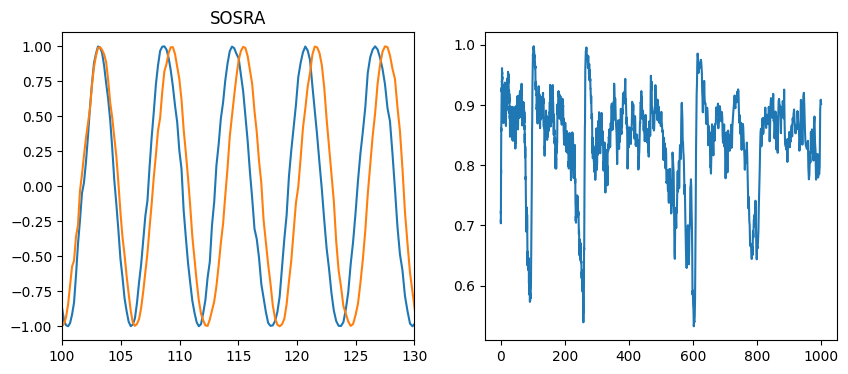

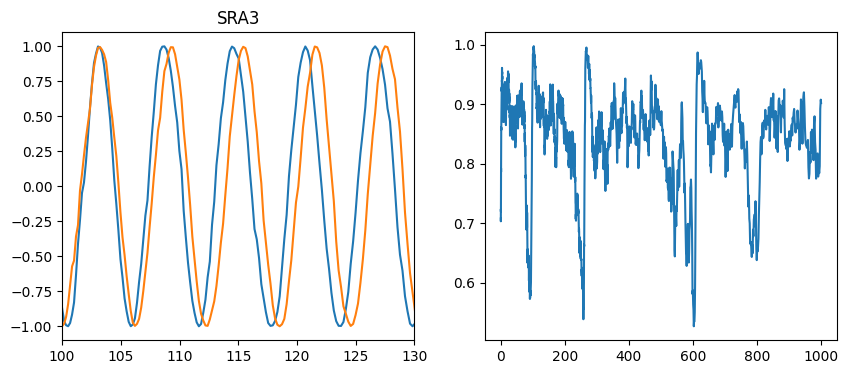

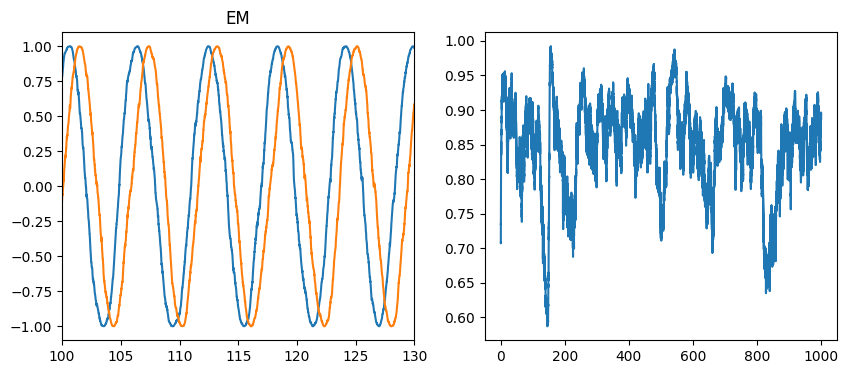

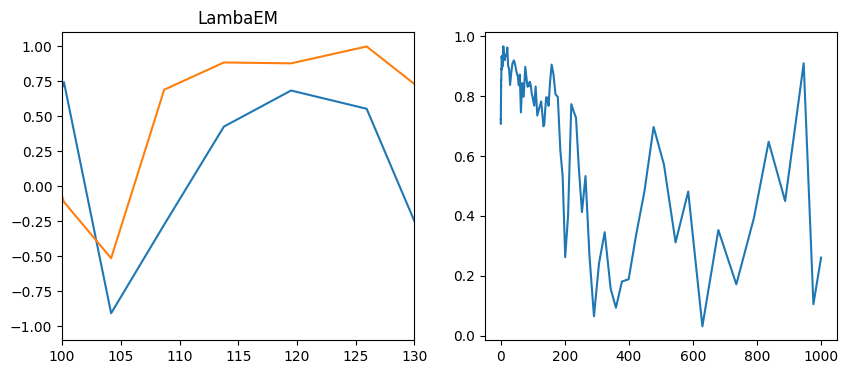

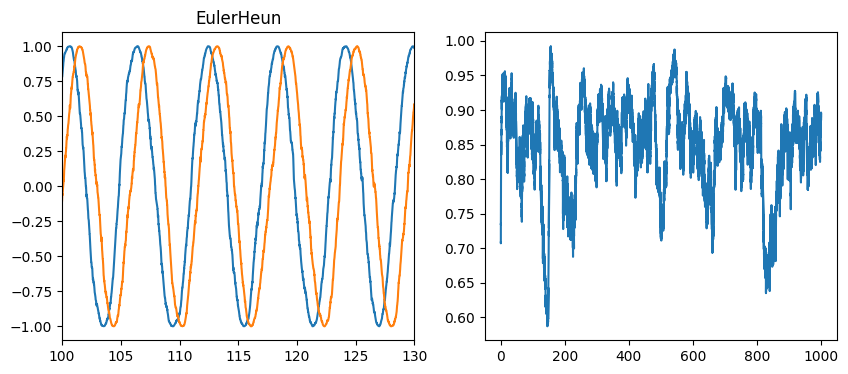

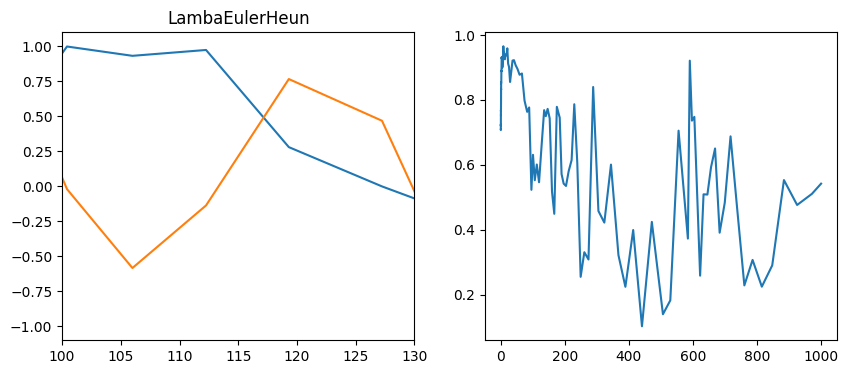

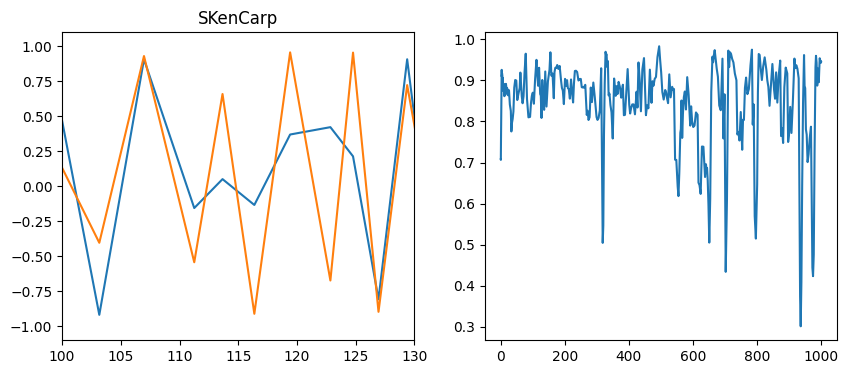

0.8389980564744699 342 SKenCarp


In [41]:
for i = 1: length(methods)
    Random.seed!(1234)
    sol = solve(prob_sde, methods[i], dt=dt)
    plot_r_phases(sol, labels[i])
end

In [53]:
prob = SDEProblem(KM_model, sKM_model, theta_0, (0.0, 20.0), p);
methods = [SOSRA(), SRA3(), EM(), LambaEM(), EulerHeun(), LambaEulerHeun(), SKenCarp()]
Random.seed!(1234)
print("SOSRA ")
@btime solve(prob, SOSRA(), dt=dt);

Random.seed!(1234)
print("SRA3")
@btime solve(prob, SRA3(), dt=dt);

Random.seed!(1234)
print("EM")
@btime solve(prob, EM(), dt=dt);

Random.seed!(1234)
print("LambdaEM")
@btime solve(prob, LambaEM(), dt=dt);

Random.seed!(1234)
print("EulerHeun")
@btime solve(prob, EulerHeun(), dt=dt);

Random.seed!(1234)
print("LambdaEulerHeun")
@btime solve(prob, LambaEulerHeun(), dt=dt);

Random.seed!(1234)
print("SKenCarp")
@btime solve(prob, SKenCarp(), dt=dt);

SOSRA   37.016 ms (405766 allocations: 13.33 MiB)
SRA3  37.312 ms (405786 allocations: 13.33 MiB)
EM  15.317 ms (168108 allocations: 5.63 MiB)
LambdaEM  722.901 μs (8053 allocations: 281.44 KiB)
EulerHeun  30.511 ms (332111 allocations: 10.94 MiB)
LambdaEulerHeun  1.077 ms (11907 allocations: 409.22 KiB)
SKenCarp  3.166 ms (32720 allocations: 1.09 MiB)


0.8611843873626188 4429 SOSRA
0.8611106017959783 4429 SRA3
0.8545576626717237 7853 RKMil
0.8470152204630305 200002 WangLi3SMil_A
0.8526669033474158 40786 SRIW1


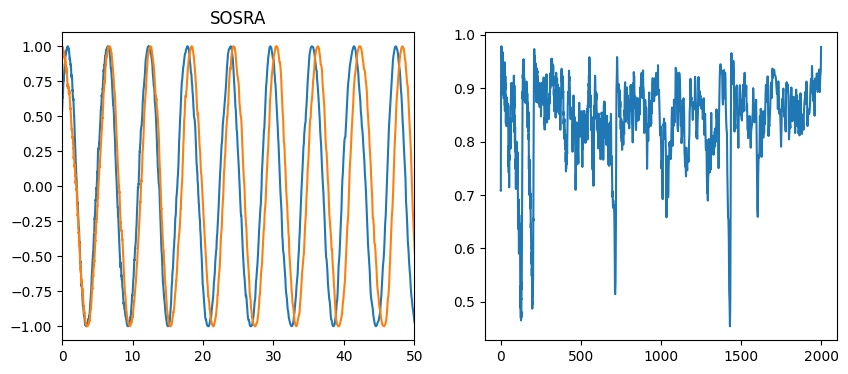

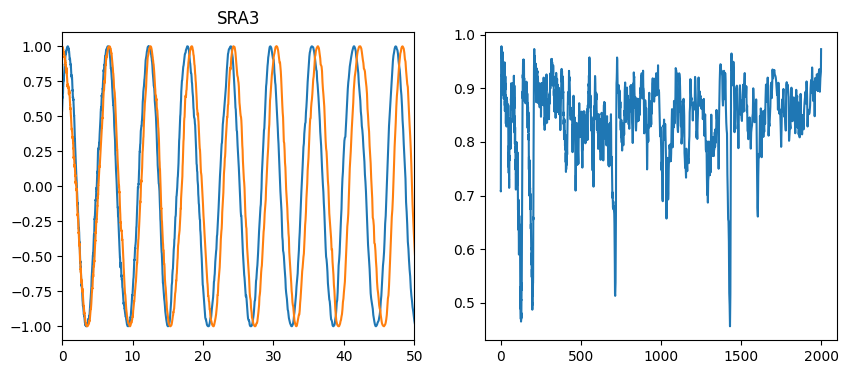

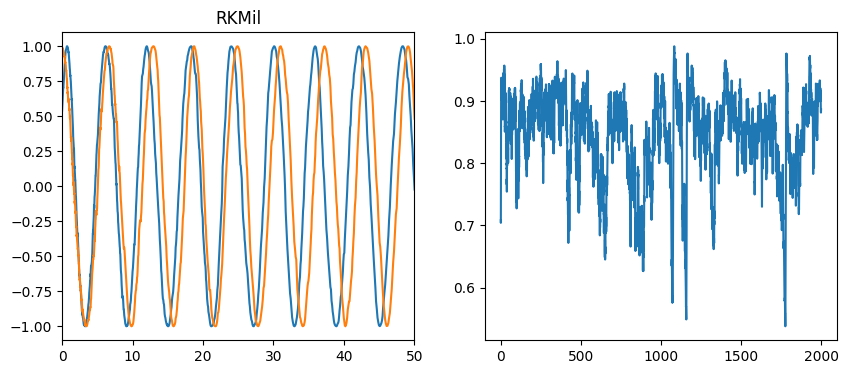

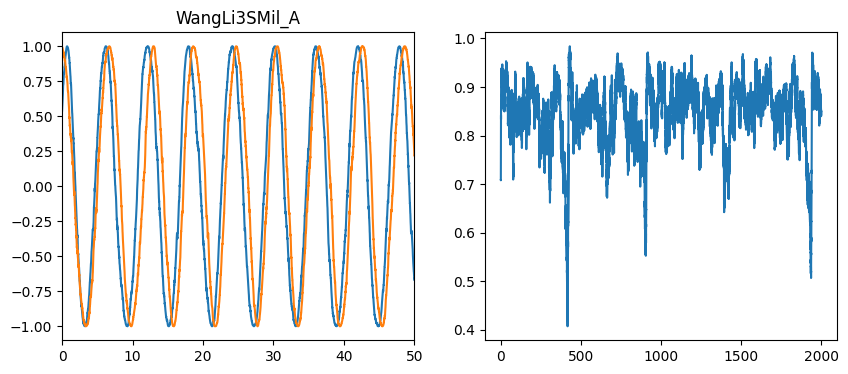

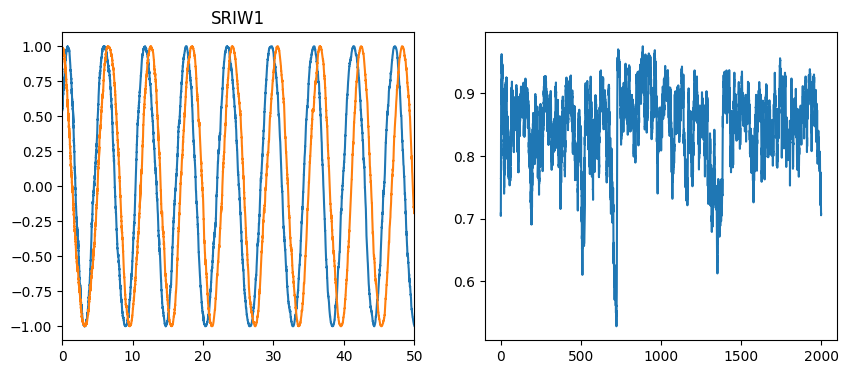

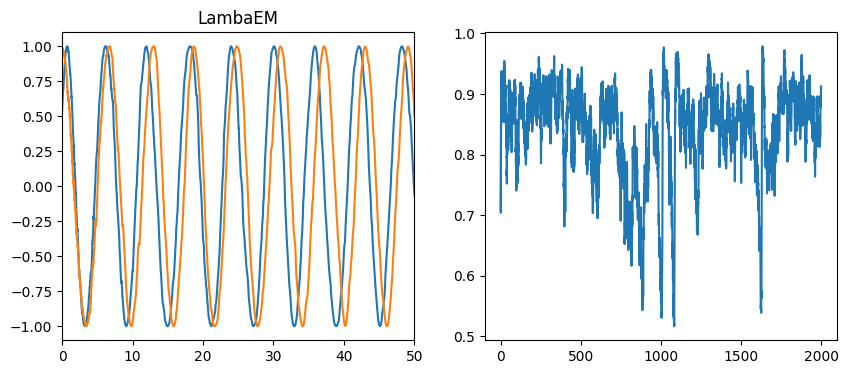

0.8511824056185926 8228 LambaEM


In [7]:
prob_sde = SDEProblem(KM_model, sKM_model, theta_0, (0.0, 2000.0), p);
# sol = solve(prob_sde, LambaEM(), dt=dt, seed=1, reltol=1e-6, abstol=1e-6)
# plot_r_phases(sol, "LambdaEM", [0, 50])
sol = solve(prob_sde, SOSRA(), dt=dt, seed=1)
plot_r_phases(sol, "SOSRA", [0, 50])
sol = solve(prob_sde, SRA3(), dt=dt, seed=1)
plot_r_phases(sol, "SRA3", [0, 50])
sol = solve(prob_sde, RKMil(), dt=dt, seed=1, reltol=1e-6, abstol=1e-6)
plot_r_phases(sol, "RKMil", [0, 50])
sol = solve(prob_sde, WangLi3SMil_A(), dt=dt, seed=1, reltol=1e-4, abstol=1e-4)
plot_r_phases(sol, "WangLi3SMil_A", [0, 50])
sol = solve(prob_sde, SRIW1(), dt=dt, seed=1, reltol=1e-4, abstol=1e-4)
plot_r_phases(sol, "SRIW1", [0, 50])
sol = solve(prob_sde, LambaEM(), dt=dt, seed=1, reltol=1e-6, abstol=1e-6)
plot_r_phases(sol, "LambaEM", [0, 50])

In [75]:
prob_sde = SDEProblem(KM_model, sKM_model, theta_0, (0.0, 50.0), p);
@btime solve(prob_sde, LambaEM(), dt=dt, seed=1, reltol=1e-6, abstol=1e-6);
@btime solve(prob_sde, SOSRA(), dt=dt, seed=1);

  19.482 ms (217802 allocations: 7.18 MiB)
  49.810 ms (551844 allocations: 18.09 MiB)


In [82]:
prob_sde = SDEProblem(KM_model, sKM_model, theta_0, (0.0, 50.0), p);
@btime solve(prob_sde, RKMil(), dt=dt, seed=1, reltol=1e-6, abstol=1e-6);

  19.763 ms (218308 allocations: 7.19 MiB)


In [86]:
prob_sde = SDEProblem(KM_model, sKM_model, theta_0, (0.0, 50.0), p);
@btime solve(prob_sde, WangLi3SMil_A(), dt=dt, seed=1, reltol=1e-4, abstol=1e-4);

  42.577 ms (510211 allocations: 16.96 MiB)


In [88]:
prob_sde = SDEProblem(KM_model, sKM_model, theta_0, (0.0, 50.0), p);
@btime solve(prob_sde, SRA3(), dt=dt, seed=1);

  50.521 ms (551864 allocations: 18.09 MiB)


In [93]:
prob_sde = SDEProblem(KM_model, sKM_model, theta_0, (0.0, 50.0), p);
@btime solve(prob_sde, SRIW1(), dt=dt, seed=1, reltol=1e-4, abstol=1e-4);

  345.710 ms (3646093 allocations: 119.44 MiB)
